In [ ]:
df = pd.read_csv(r'C:\Users\laava\Desktop\sem 6\AOML\project\MBTI\16P.csv', encoding='ISO-8859-1')
df

,Response Id,You regularly make new friends.,You spend a lot of your free time exploring various random topics that pique your interest,Seeing other people cry can easily make you feel like you want to cry too,You often make a backup plan for a backup plan.,"You usually stay calm, even under a lot of pressure","At social events, you rarely try to introduce yourself to new people and mostly talk to the ones you already know",You prefer to completely finish one project before starting another.,You are very sentimental.,You like to use organizing tools like schedules and lists.,...,You believe that pondering abstract philosophical questions is a waste of time.,"You feel more drawn to places with busy, bustling atmospheres than quiet, intimate places.",You know at first glance how someone is feeling.,You often feel overwhelmed.,You complete things methodically without skipping over any steps.,You are very intrigued by things labeled as controversial.,You would pass along a good opportunity if you thought someone else needed it more.,You struggle with deadlines.,You feel confident that things will work out for you.,Personality
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,-1,0,0,0,0,0,ENFP
1,1,0,0,-2,-3,-1,2,-2,0,3,...,0,-2,0,2,0,-1,-1,-1,3,ISFP
2,2,0,0,2,0,-1,2,0,0,1,...,0,2,0,2,-1,0,1,2,1,INFJ
3,3,0,-1,3,-1,0,0,-2,0,-2,...,0,0,-1,-1,0,1,0,-2,-1,ISTP
4,4,0,0,-1,0,2,-1,-2,0,1,...,0,1,0,2,0,1,-1,2,-1,ENFJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,59994,0,-1,0,-3,-2,2,1,0,1,...,0,2,0,1,0,0,2,3,3,INFJ
59995,59995,0,0,-2,1,3,0,-3,0,2,...,0,1,0,0,0,0,2,0,-2,ESTP
59996,59996,0,0,1,0,-2,-2,0,0,-1,...,-1,2,0,-3,0,1,-1,0,-1,ISTP
59997,59997,0,0,1,-1,-2,-1,2,0,1,...,0,2,0,2,0,0,0,1,0,ISTJ


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE

# Load dataset
file_path = r"C:\Users\laava\Desktop\sem 6\AOML\project\MBTI\16P.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Encode target variable (Personality)
label_encoder = LabelEncoder()
df["Personality_Encoded"] = label_encoder.fit_transform(df["Personality"])

# Separate features and target
X = df.drop(columns=["Response Id", "Personality", "Personality_Encoded"], errors='ignore')
y = df["Personality_Encoded"]

# Train Random Forest for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance scores
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Feature Reduction using Recursive Feature Elimination (RFE)
num_features_to_select = 30  # Adjust based on the number of questions you want to keep
rfe = RFE(estimator=rf_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]

print("Top Features Based on Importance:")
print(feature_importance)

print("\nSelected Features After Reduction:")
print(selected_features.tolist())

Top Features Based on Importance:
                                              Feature  Importance
19  You are prone to worrying that things will tak...    0.027035
28  You often end up doing things at the last poss...    0.025886
17  Your happiness comes more from helping others ...    0.025477
36                    You enjoy going to art museums.    0.025444
5   At social events, you rarely try to introduce ...    0.025239
11  You are not too interested in discussing vario...    0.025155
26                 Your mood can change very quickly.    0.024821
32  You find it easy to empathize with a person wh...    0.024601
52  You feel more drawn to places with busy, bustl...    0.024270
54                        You often feel overwhelmed.    0.024214
29  You have always been fascinated by the questio...    0.024183
12  You are more inclined to follow your head than...    0.024124
58                       You struggle with deadlines.    0.024087
13  You usually prefer just doing what you

In [ ]:
print(f"\nRandom Forest Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.5657


In [ ]:
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Encode target variable (Personality)
label_encoder = LabelEncoder()
df["Personality_Encoded"] = label_encoder.fit_transform(df["Personality"])

# Separate features and target
X = df.drop(columns=["Response Id", "Personality", "Personality_Encoded"], errors='ignore')
y = df["Personality_Encoded"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna tuning
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Get best hyperparameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train optimized model
optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)
y_pred_optimized = optimized_rf_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": optimized_rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Feature Reduction using Recursive Feature Elimination (RFE)
num_features_to_select = 10  # Adjust based on the number of questions you want to keep
rfe = RFE(estimator=optimized_rf_model, n_features_to_select=num_features_to_select)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]

print("Top Features Based on Importance:")
print(feature_importance.head(10))

print("\nSelected Features After Reduction:")
print(selected_features.tolist())

print(f"\nOptimized Random Forest Accuracy: {optimized_accuracy:.4f}")

[I 2025-03-30 01:11:51,336] A new study created in memory with name: no-name-6c37b0fa-bedf-4ace-af8b-8a7f5e35edba
[I 2025-03-30 01:11:55,375] Trial 0 finished with value: 0.9428333333333333 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9428333333333333.
[I 2025-03-30 01:12:01,525] Trial 1 finished with value: 0.96575 and parameters: {'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.96575.
[I 2025-03-30 01:12:09,535] Trial 2 finished with value: 0.9455833333333333 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.96575.
[I 2025-03-30 01:12:18,996] Trial 3 finished with value: 0.9565833333333333 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.96575.
[I 2025-03-30 01:12:25,

Best Parameters: {'n_estimators': 150, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2}
Top Features Based on Importance:
                                              Feature  Importance
19  You are prone to worrying that things will tak...    0.027957
28  You often end up doing things at the last poss...    0.027448
5   At social events, you rarely try to introduce ...    0.026918
36                    You enjoy going to art museums.    0.026914
26                 Your mood can change very quickly.    0.026546
32  You find it easy to empathize with a person wh...    0.026288
11  You are not too interested in discussing vario...    0.026068
17  Your happiness comes more from helping others ...    0.025486
54                        You often feel overwhelmed.    0.025280
38        You like to have a to-do list for each day.    0.025186

Selected Features After Reduction:
['Seeing other people cry can easily make you feel like you want to cry too', 'You enjoy participatin

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the best parameters
best_params = {
    "n_estimators": 150,
    "max_depth": 17,
    "min_samples_split": 6,
    "min_samples_leaf": 2,
    "random_state": 42
}

# Initialize and train the model
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

# Evaluate on the test set
accuracy = rf.score(X_test, y_test)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.9752


In [ ]:
import joblib

# Save the Random Forest model
joblib.dump(rf, "rf_model.pkl")
print("✅ Random Forest model saved as 'rf_model.pkl'")

✅ Random Forest model saved as 'rf_model.pkl'


c:\Users\laava\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


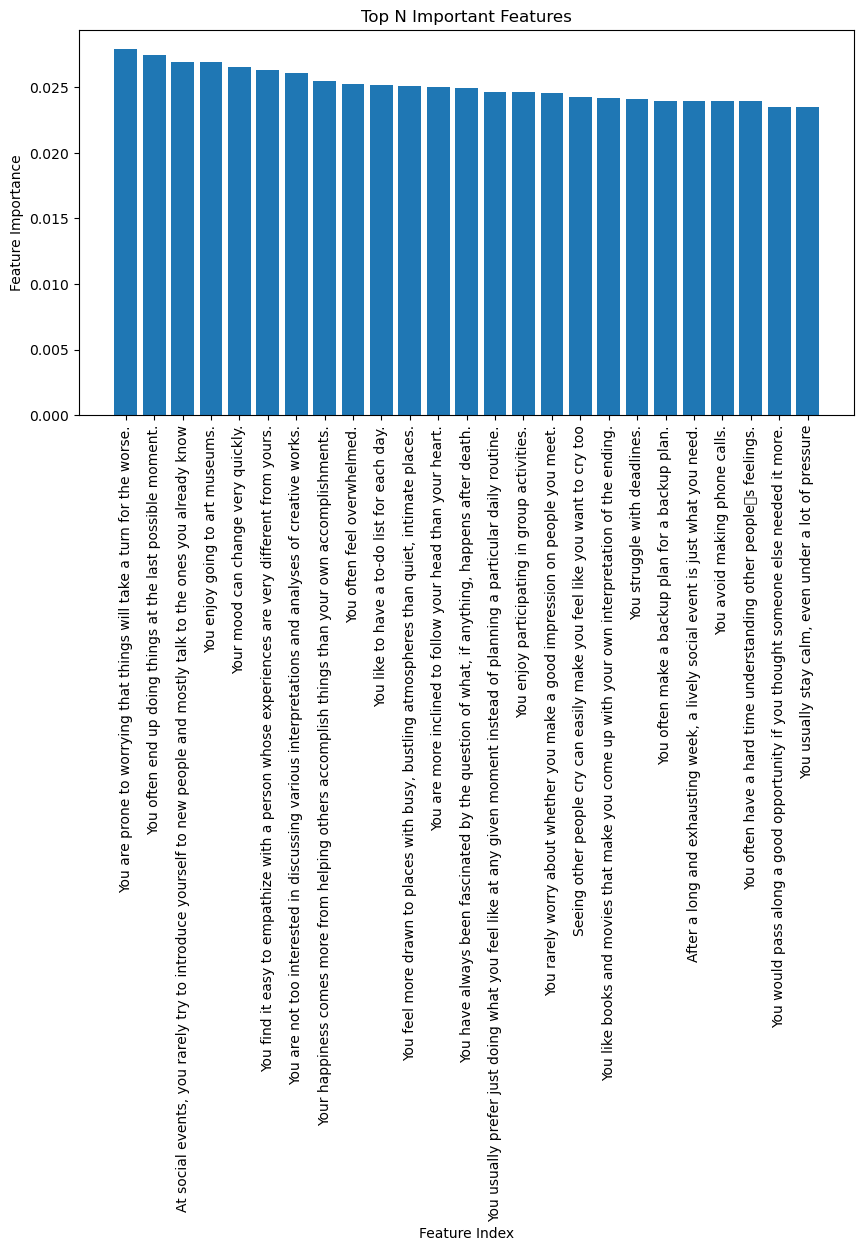

Accuracy after feature selection: 0.9166


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Get feature importances
importances = rf.feature_importances_

# Sort and select top N features
indices = np.argsort(importances)[::-1]
top_n = 25  # Adjust based on trade-off
selected_features = X_train.columns[indices[:top_n]]

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), selected_features, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top N Important Features")
plt.show()

# Train new model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
rf.fit(X_train_selected, y_train)
accuracy = rf.score(X_test_selected, y_test)
print(f"Accuracy after feature selection: {accuracy:.4f}")

In [ ]:
import joblib

# Save the trained model
joblib.dump(rf, "random_forest_model.pkl")

# Save selected features
joblib.dump(selected_features, "selected_features.pkl")

print("Model and selected features saved successfully!")

Model and selected features saved successfully!


In [ ]:
# Print the top 20 selected feature names (questions)
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

1. You are prone to worrying that things will take a turn for the worse.
2. You often end up doing things at the last possible moment.
3. At social events, you rarely try to introduce yourself to new people and mostly talk to the ones you already know
4. You enjoy going to art museums.
5. Your mood can change very quickly.
6. You find it easy to empathize with a person whose experiences are very different from yours.
7. You are not too interested in discussing various interpretations and analyses of creative works.
8. Your happiness comes more from helping others accomplish things than your own accomplishments.
9. You often feel overwhelmed.
10. You like to have a to-do list for each day.
11. You feel more drawn to places with busy, bustling atmospheres than quiet, intimate places.
12. You are more inclined to follow your head than your heart.
13. You have always been fascinated by the question of what, if anything, happens after death.
14. You usually prefer just doing what you feel l

In [ ]:
# Get the mapping of personality names to encodings
personality_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the mapping
print("Personality Name to Encoding Mapping:")
for personality, encoding in personality_mapping.items():
    print(f"{personality}: {encoding}")

Personality Name to Encoding Mapping:
ENFJ: 0
ENFP: 1
ENTJ: 2
ENTP: 3
ESFJ: 4
ESFP: 5
ESTJ: 6
ESTP: 7
INFJ: 8
INFP: 9
INTJ: 10
INTP: 11
ISFJ: 12
ISFP: 13
ISTJ: 14
ISTP: 15
